In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
train_df = pd.read_csv('train.csv', parse_dates=True, index_col='Date')
test_df = pd.read_csv('test.csv', parse_dates=True, index_col='Date')
feature_df = pd.read_csv('features.csv', parse_dates=True, index_col='Date')
store_df = pd.read_csv('stores.csv')

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 4 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
dtypes: bool(1), float64(1), int64(2)
memory usage: 13.3 MB


In [4]:
train_df.head(10)

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False
2010-03-12,1,1,21043.39,False
2010-03-19,1,1,22136.64,False
2010-03-26,1,1,26229.21,False
2010-04-02,1,1,57258.43,False


In [5]:
feature_df.head(10)

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
Date,,,,,,,,,,,
2010-02-05,1,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
2010-02-12,1,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2010-02-19,1,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
2010-02-26,1,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
2010-03-05,1,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
2010-03-12,1,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,False
2010-03-19,1,54.58,2.720,NaN,NaN,NaN,NaN,NaN,211.215635,8.106,False
2010-03-26,1,51.45,2.732,NaN,NaN,NaN,NaN,NaN,211.018042,8.106,False
2010-04-02,1,62.27,2.719,NaN,NaN,NaN,NaN,NaN,210.820450,7.808,False


In [6]:
test_df.head(10)

,Store,Dept,IsHoliday
Date,,,
2012-11-02,1,1,False
2012-11-09,1,1,False
2012-11-16,1,1,False
2012-11-23,1,1,True
2012-11-30,1,1,False
2012-12-07,1,1,False
2012-12-14,1,1,False
2012-12-21,1,1,False
2012-12-28,1,1,True


In [7]:
store_df.head(10)

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875
5,6,A,202505
6,7,B,70713
7,8,A,155078
8,9,B,125833
9,10,B,126512


In [8]:
# DataFrame for Store 1, Dept 1
store1_dept1_df = train_df[(train_df.Store==1) &(train_df.Dept==1)]

### Visualize the Data

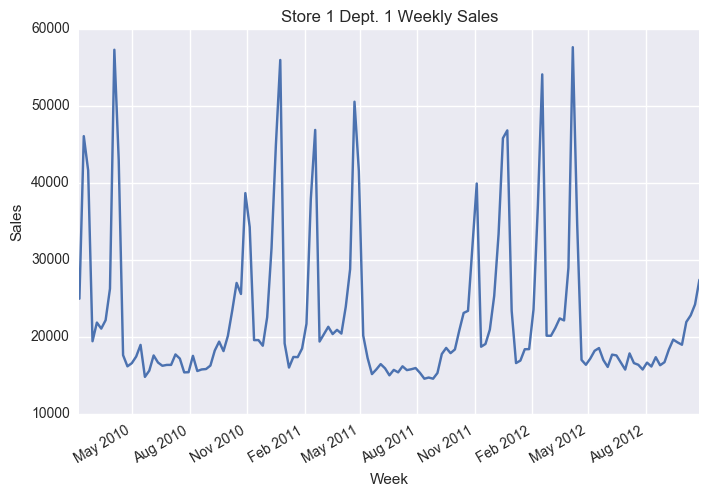

In [9]:
#stationary if its statistical properties such as mean, variance remain constant over time.
x = store1_dept1_df.index
y = store1_dept1_df['Weekly_Sales']
plt.plot(x,y)
plt.gcf().autofmt_xdate()
plt.title('Store 1 Dept. 1 Weekly Sales')
plt.xlabel('Week')
plt.ylabel('Sales')

There is an trend of four spikes during an annual year. 
This represents there's a seasonality to it
This is only for store 1 and dept 1

Let's look at this by the average Weekly_Sales of all Stores/Department over the same time period.

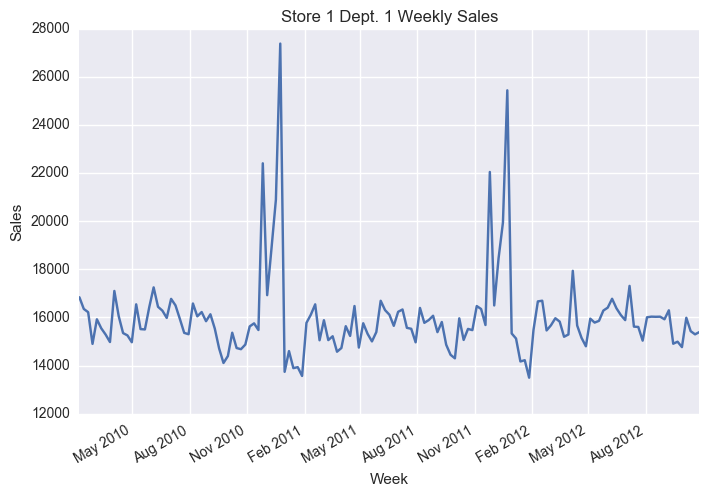

In [10]:
x = train_df.index.drop_duplicates()
y = train_df.groupby(lambda x: x.date)['Weekly_Sales'].mean()

plt.plot(x,y)
plt.gcf().autofmt_xdate()
plt.title('All Stores & Department')
plt.xlabel('Week')
plt.ylabel('Sales')

Now the spikes actually got reduced to two spikes only - Novement and December

In order to look at this clearly and ensure data is stationary before using ARIMA model.

In [11]:
store1_dept1_df.Weekly_Sales.describe()

count      143.000000
mean     22513.322937
std       9854.349032
min      14537.370000
25%      16494.630000
50%      18535.480000
75%      23214.215000
max      57592.120000
Name: Weekly_Sales, dtype: float64

In [12]:
a = train_df.groupby(lambda x: x.date)['Weekly_Sales'].mean().to_frame()
a.info()

<class 'pandas.core.frame.DataFrame'>
Index: 143 entries, 2010-02-05 to 2012-10-26
Data columns (total 1 columns):
Weekly_Sales    143 non-null float64
dtypes: float64(1)
memory usage: 2.2+ KB


/usr/local/lib/python3.5/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


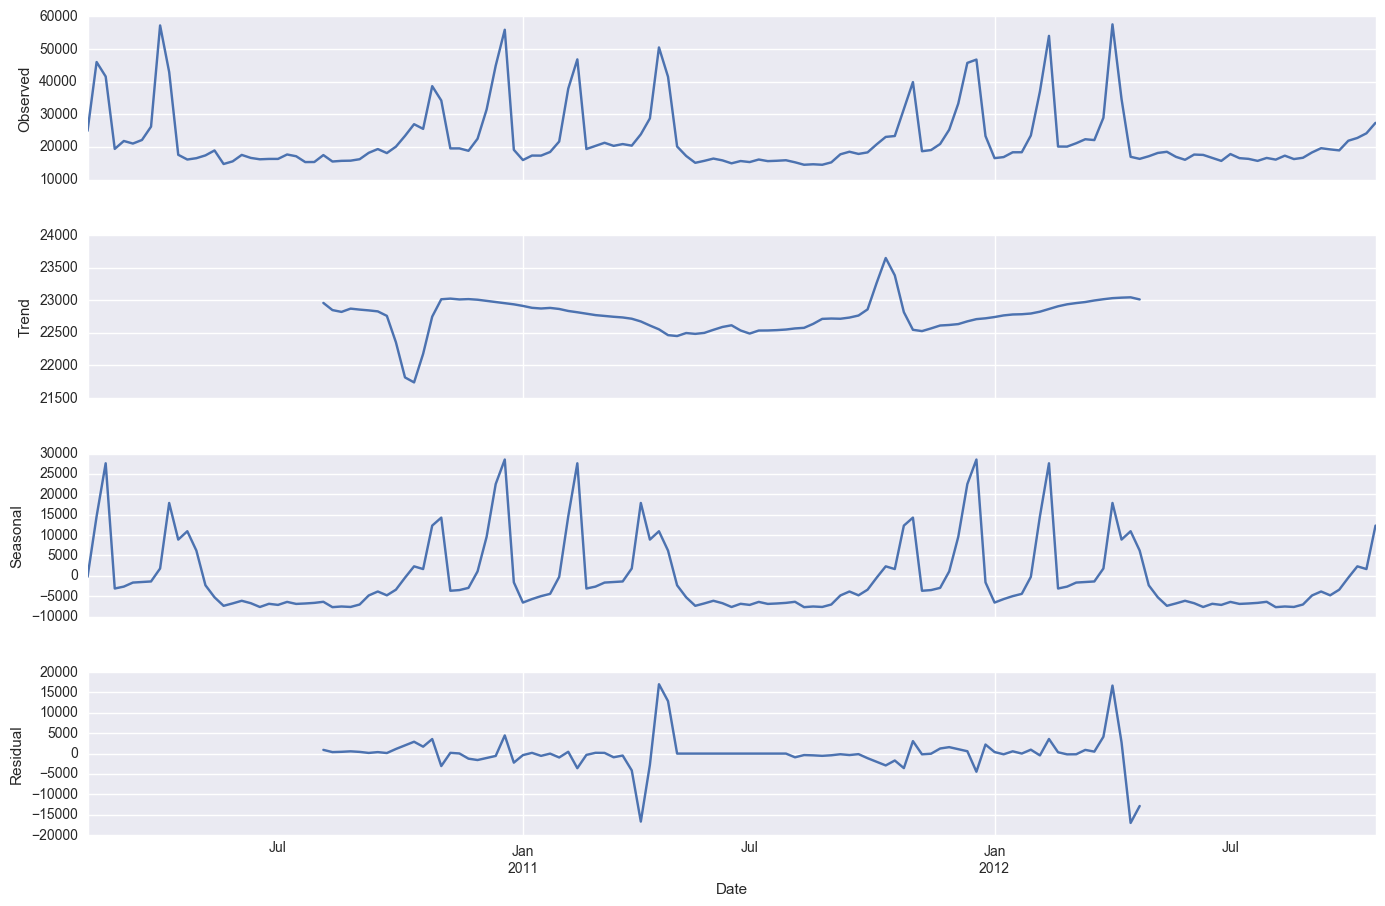

In [13]:
train_df_Sales = train_df.groupby(lambda x: x.date)['Weekly_Sales'].mean().to_frame()

decomposition = seasonal_decompose(store1_dept1_df['Weekly_Sales'])  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 10)

## Stationarize Data

In [14]:
# Dickey-Fuller test 
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.gcf().autofmt_xdate()
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


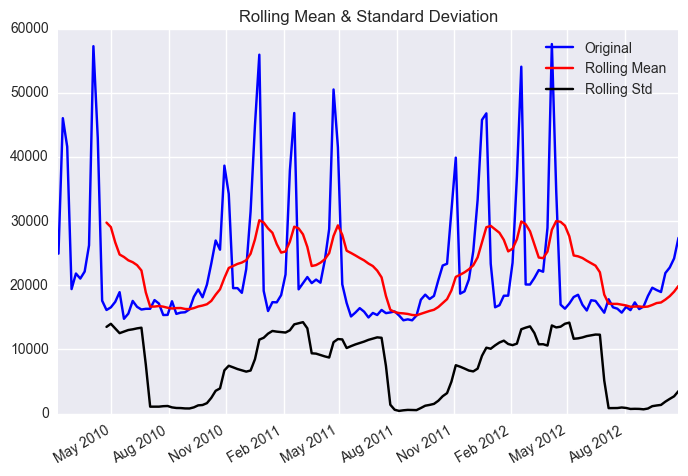

Results of Dickey-Fuller Test:
Test Statistic                  -2.522164
p-value                          0.110174
#Lags Used                       6.000000
Number of Observations Used    136.000000
Critical Value (10%)            -2.578234
Critical Value (5%)             -2.883037
Critical Value (1%)             -3.479372
dtype: float64


In [15]:
test_stationarity(store1_dept1_df['Weekly_Sales'])

we can transform the data to make it more stationary.
There are various transformations you can do to stationarize the data.
- Logarithmic
- First Difference
- Seasonal Difference
- Seasonal Adjustment


P-value is 0.11 which is too high when we are looking for sig. level of 5%.
Also we can visually tell the mean and standard deviation is 
Let's try taking a log first

#### Transformation: Log

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


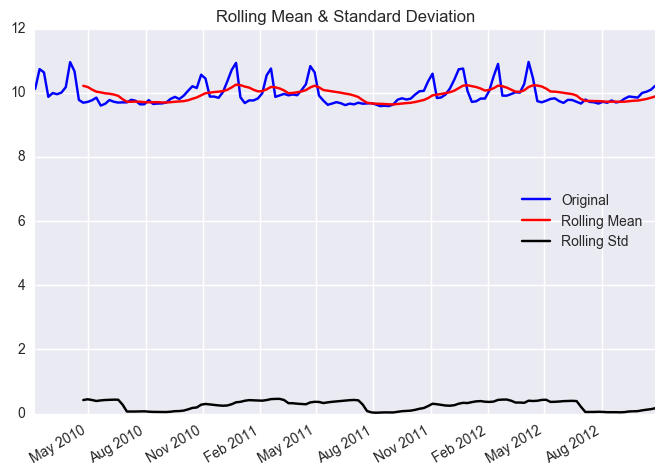

Results of Dickey-Fuller Test:
Test Statistic                  -3.061511
p-value                          0.029536
#Lags Used                      10.000000
Number of Observations Used    132.000000
Critical Value (10%)            -2.578586
Critical Value (5%)             -2.883697
Critical Value (1%)             -3.480888
dtype: float64


In [16]:
store1_dept1_df.weekly_sales_log= store1_dept1_df['Weekly_Sales'].apply(lambda x: np.log(x))  
test_stationarity(store1_dept1_df.weekly_sales_log)

#### Moving average

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=48,center=False).mean()
  if __name__ == '__main__':


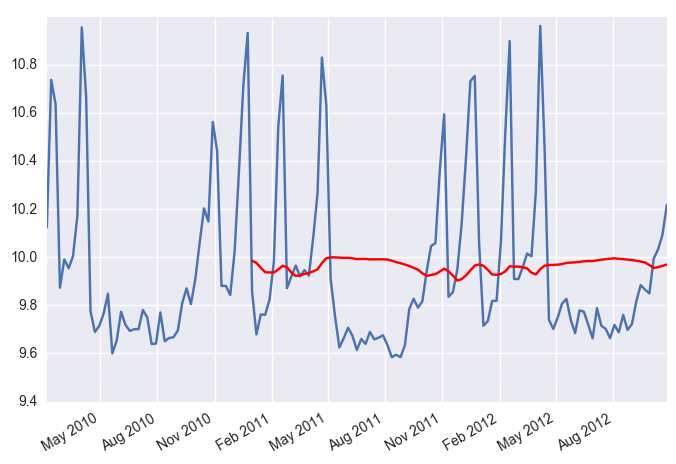

In [58]:
moving_avg = pd.rolling_mean(store1_dept1_df.weekly_sales_log,48)
plt.plot(store1_dept1_df.weekly_sales_log)
plt.gcf().autofmt_xdate()
plt.plot(moving_avg, color='red')

In [59]:
ts_log_moving_avg_diff = store1_dept1_df.weekly_sales_log - moving_avg
ts_log_moving_avg_diff.head(12)

Date
2010-02-05   NaN
2010-02-12   NaN
2010-02-19   NaN
2010-02-26   NaN
2010-03-05   NaN
2010-03-12   NaN
2010-03-19   NaN
2010-03-26   NaN
2010-04-02   NaN
2010-04-09   NaN
2010-04-16   NaN
2010-04-23   NaN
Name: Weekly_Sales, dtype: float64

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


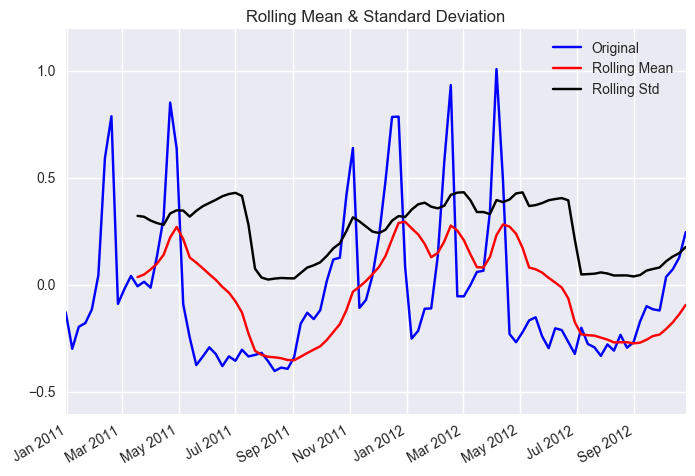

Results of Dickey-Fuller Test:
Test Statistic                 -1.786368
p-value                         0.387250
#Lags Used                      6.000000
Number of Observations Used    89.000000
Critical Value (10%)           -2.584410
Critical Value (5%)            -2.894607
Critical Value (1%)            -3.506057
dtype: float64


In [60]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

#### Exponential Moving average

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(min_periods=0,adjust=True,ignore_na=False,halflife=12).mean()
  if __name__ == '__main__':


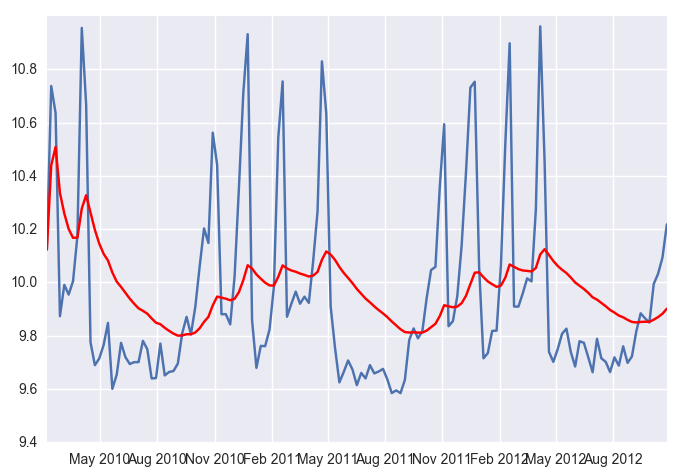

In [20]:
expwighted_avg = pd.ewma(store1_dept1_df.weekly_sales_log, halflife=12)
plt.plot(store1_dept1_df.weekly_sales_log)
plt.plot(expwighted_avg, color='red')

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


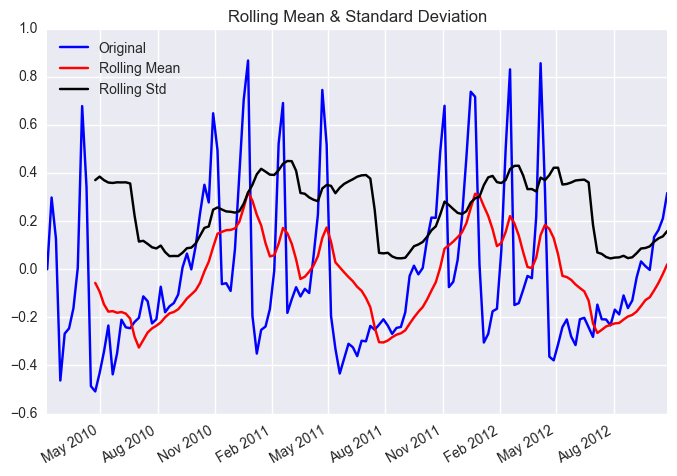

Results of Dickey-Fuller Test:
Test Statistic                  -2.233013
p-value                          0.194482
#Lags Used                       6.000000
Number of Observations Used    136.000000
Critical Value (10%)            -2.578234
Critical Value (5%)             -2.883037
Critical Value (1%)             -3.479372
dtype: float64


In [21]:
ts_log_ewma_diff = store1_dept1_df.weekly_sales_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

It looks like rolling mean is varying slightly but no specific trend.
Test Statistic is smaller than 5% critical value, meaning we can say with 95% confidence that this is a stationary series.

Let's try First Difference

#### Transformation:  First Difference

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


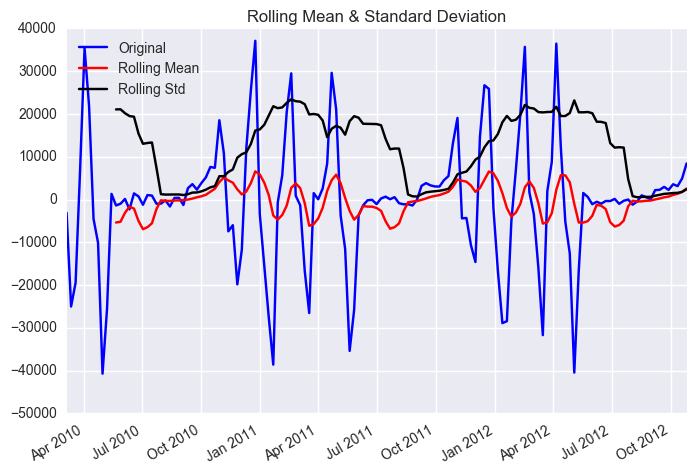

Results of Dickey-Fuller Test:
Test Statistic                  -3.670730
p-value                          0.004544
#Lags Used                       8.000000
Number of Observations Used    130.000000
Critical Value (10%)            -2.578770
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
dtype: float64


In [38]:
store1_dept1_df['first_difference'] = store1_dept1_df.Weekly_Sales - store1_dept1_df.Weekly_Sales.shift(4)  
test_stationarity(store1_dept1_df.first_difference.dropna(inplace=False))

p-value is even lower now.
Let's try Seasonal Difference

#### Transformation: Seasonal Difference

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


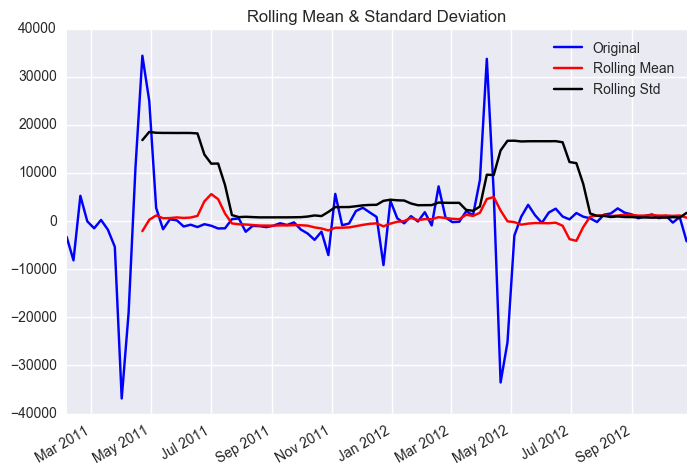

Results of Dickey-Fuller Test:
Test Statistic                -8.892006e+00
p-value                        1.235262e-14
#Lags Used                     1.000000e+00
Number of Observations Used    8.900000e+01
Critical Value (10%)          -2.584410e+00
Critical Value (5%)           -2.894607e+00
Critical Value (1%)           -3.506057e+00
dtype: float64


In [39]:
store1_dept1_df['seasonal_difference'] = store1_dept1_df.Weekly_Sales - store1_dept1_df.Weekly_Sales.shift(52)  
test_stationarity(store1_dept1_df.seasonal_difference.dropna(inplace=False))

#### Transformation: Log First Difference

So we cannot use seasonal difference.
Since log and first difference seem to work, we can try a log first difference

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


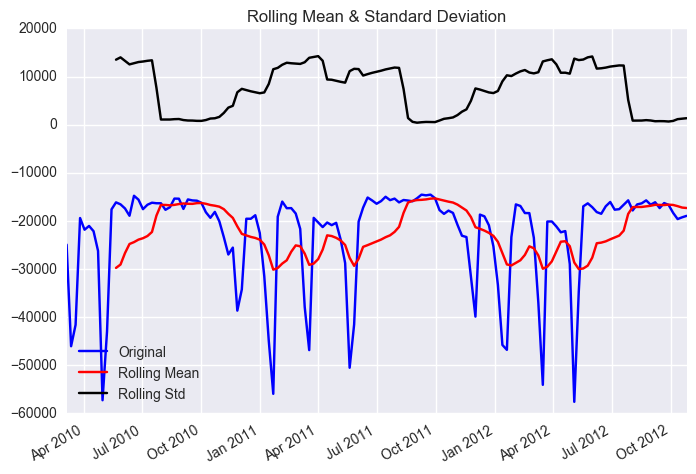

Results of Dickey-Fuller Test:
Test Statistic                  -2.405479
p-value                          0.140196
#Lags Used                       6.000000
Number of Observations Used    132.000000
Critical Value (10%)            -2.578586
Critical Value (5%)             -2.883697
Critical Value (1%)             -3.480888
dtype: float64


In [45]:
store1_dept1_df['log_first_difference'] = store1_dept1_df.weekly_sales_log- store1_dept1_df.Weekly_Sales.shift(4)  
test_stationarity(store1_dept1_df.log_first_difference.dropna(inplace=False))

#### Transformation: Log Seasonal Difference

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


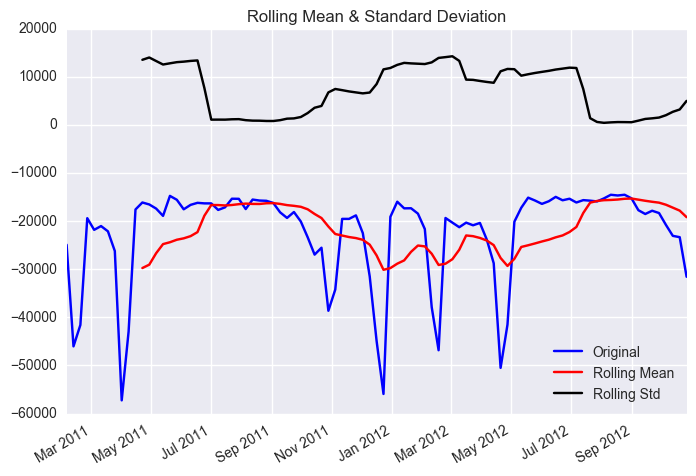

Results of Dickey-Fuller Test:
Test Statistic                -6.071284e+00
p-value                        1.149234e-07
#Lags Used                     1.000000e+00
Number of Observations Used    8.900000e+01
Critical Value (10%)          -2.584410e+00
Critical Value (5%)           -2.894607e+00
Critical Value (1%)           -3.506057e+00
dtype: float64


In [46]:
store1_dept1_df['log_seasonal_difference'] = store1_dept1_df.weekly_sales_log- store1_dept1_df.Weekly_Sales.shift(52)  
test_stationarity(store1_dept1_df.log_seasonal_difference.dropna(inplace=False))

It seems like 1st differnce gives out the best result.

## Decomposition

/usr/local/lib/python3.5/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


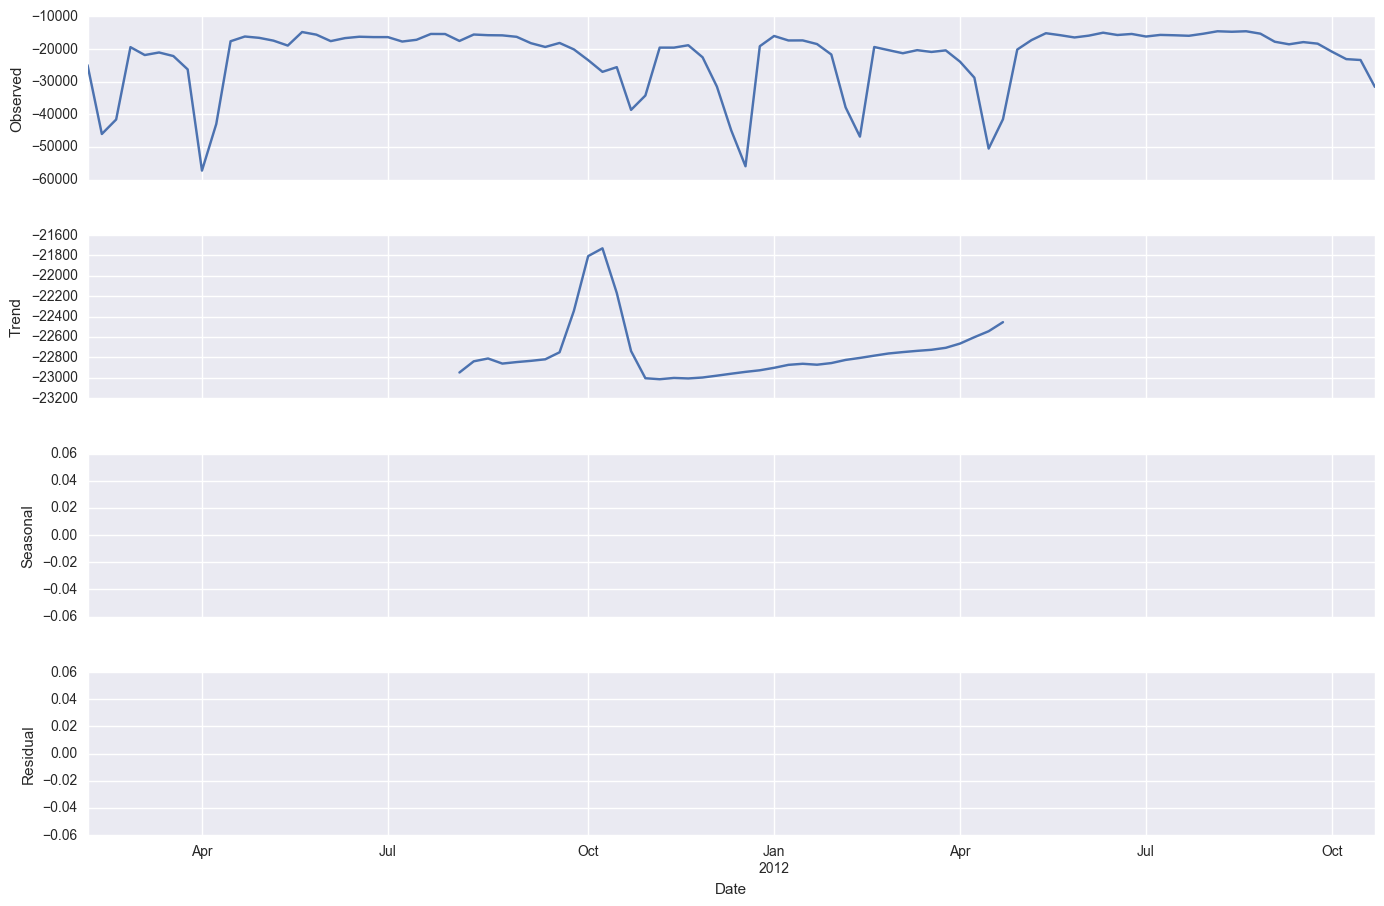

In [47]:
decomposition = seasonal_decompose(store1_dept1_df['log_seasonal_difference'].dropna())
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 10)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


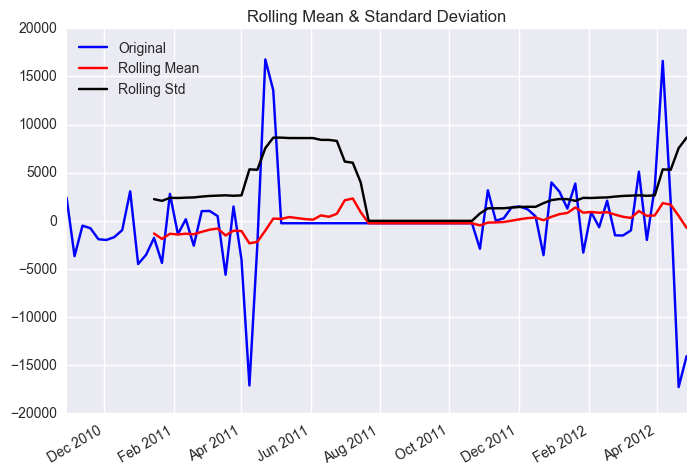

Results of Dickey-Fuller Test:
Test Statistic                -8.117312e+00
p-value                        1.181440e-12
#Lags Used                     1.000000e+00
Number of Observations Used    7.700000e+01
Critical Value (10%)          -2.587223e+00
Critical Value (5%)           -2.899878e+00
Critical Value (1%)           -3.518281e+00
dtype: float64


In [28]:
ts_log_decompose = decomposition.resid
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

The Dickey-Fuller test statistic is significantly lower than the 1% critical value. So this TS is very close to stationary. 

### ARIMA

Auto-Regressive Integrated Moving Averages. 

1. Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
2. Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
3. Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.

To determine p and q:
- Autocorrelation Function (ACF): It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).
- Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4

#### Split Dataframe into Training and Testing data

In [49]:
# # split into train and test sets
# X = store1_dept1_df['Weekly_Sales']
# train_size = int(len(X) * 0.70)
# train, test = X[1:train_size], X[train_size:]
# train_X, train_y = train[:,0], train[:,1]
# test_X, test_y = test[:,0], test[:,1]

In [29]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [30]:
lag_acf = acf(store1_dept1_df.weekly_sales_log, nlags=20)
lag_pacf = pacf(store1_dept1_df.weekly_sales_log, nlags=20, method='ols')

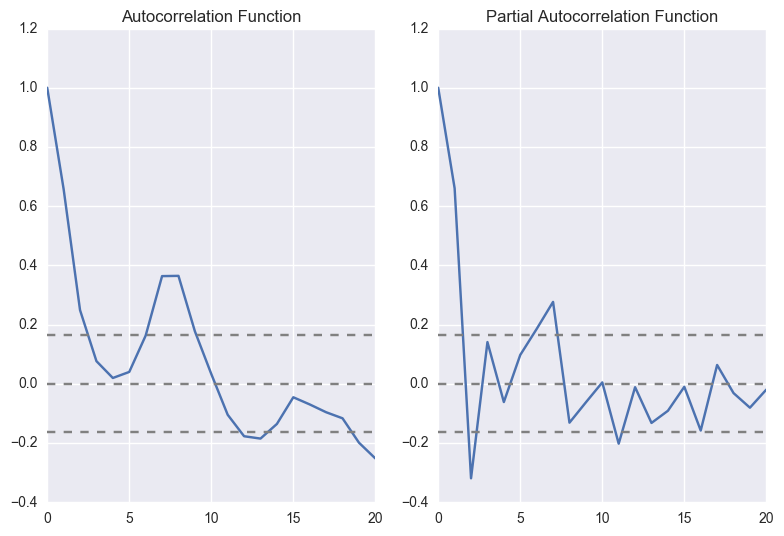

In [31]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(new_store1_dept1_df)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(new_store1_dept1_df)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(new_store1_dept1_df)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(new_store1_dept1_df)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

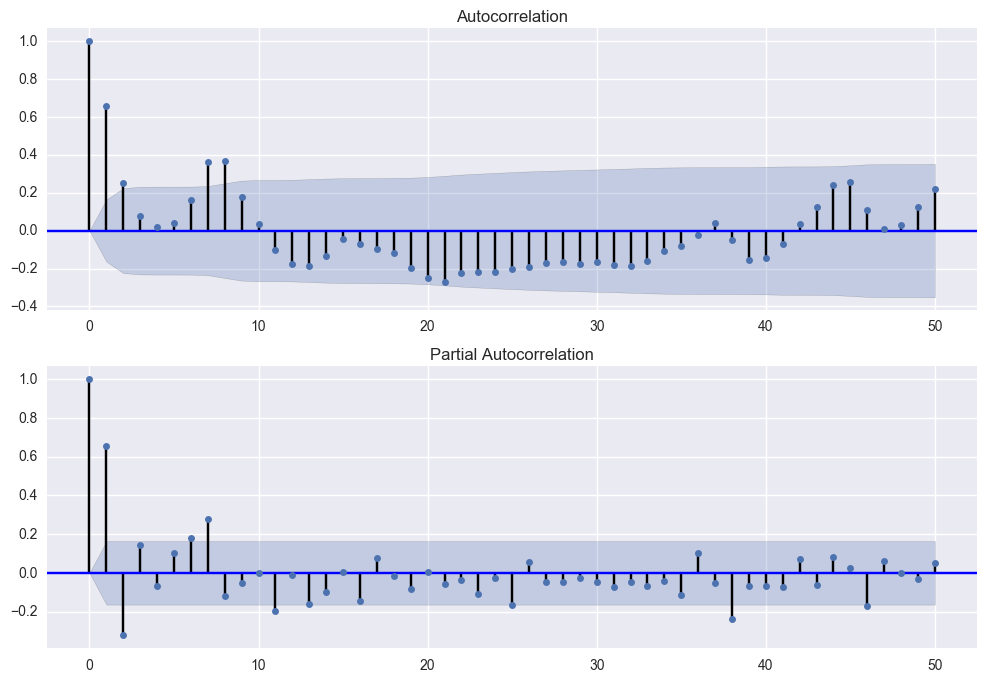

In [32]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(store1_dept1_df.weekly_sales_log, lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(store1_dept1_df.weekly_sales_log, lags=50, ax=ax2)

Running the ACF, we can see that there is a positive correlation with the first 10 lags that is perhaps significant for the first 5 lags.

Runing the PACF, we can see there is a positive co


    p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=5.
    q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=2.



In [33]:
from statsmodels.tsa.arima_model import ARIMA

### AR Model

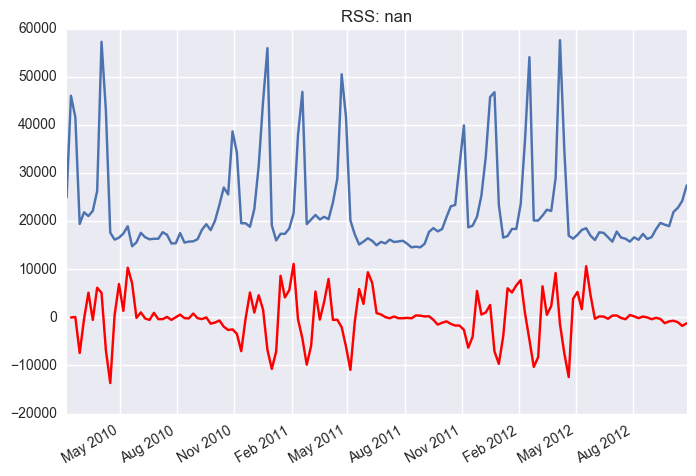

In [34]:
model = ARIMA(new_store1_dept1_df, order=(5, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(new_store1_dept1_df)
plt.gcf().autofmt_xdate()
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-new_store1_dept1_df)**2))

### MA Model

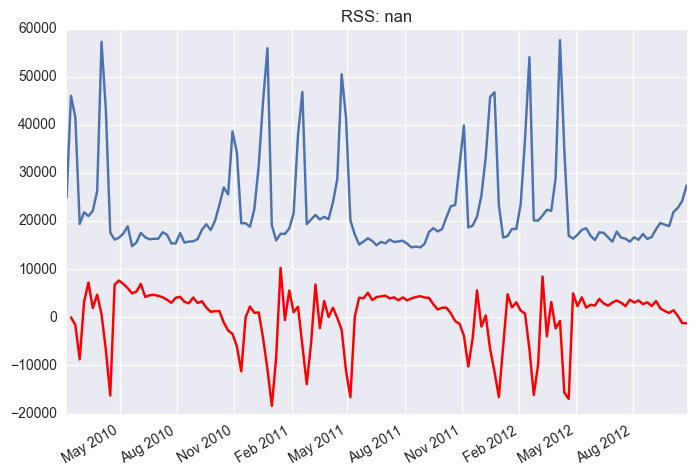

In [35]:
model = ARIMA(new_store1_dept1_df, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(new_store1_dept1_df)
plt.gcf().autofmt_xdate()
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-new_store1_dept1_df)**2))

### Combined Model

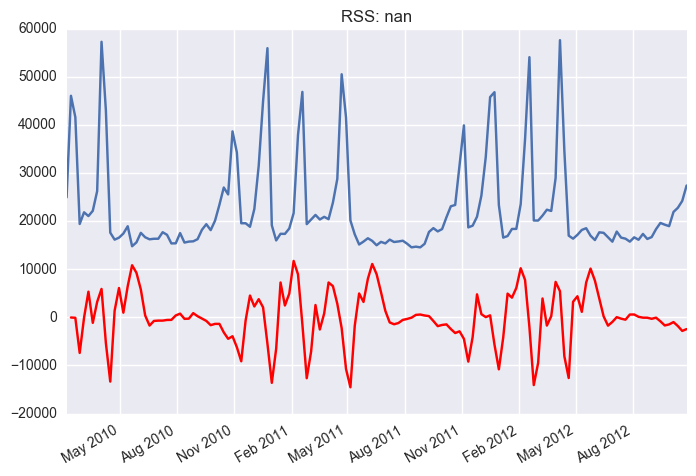

In [36]:
model = ARIMA(new_store1_dept1_df, order=(5, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(new_store1_dept1_df)
plt.gcf().autofmt_xdate()
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-new_store1_dept1_df)**2))